In [2]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab

import os
import json
from glob import glob

# from uncertainties import unumpy as unp
# from uncertainties import ufloat, umath

from options import *
from constants import *

# nom_vals = unp.nominal_values
# std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
NFFT = 1024
SAMPLE_RATE = 2_048_000
H21 = 1.420405751768e9  # Hz

In [4]:
def load(dataset: str):
    raw_data = np.fromfile(dataset, np.complex64)
    with open(dataset.replace("raw.dat", "params.json"), "r") as file:
        params = json.load(file)
    
    spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
    frequencies += params['frequency']

    return raw_data, (spectrum, frequencies), params

In [6]:
spectra = []
freq = None

files = glob("../data/Vitesse*.dat")
for file in files:
    _, (spectrum, freq), _ = load(file)
    spectra.append(spectrum)

In [19]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [35]:
def normalise_data(signal: np.ndarray, noise: np.ndarray) -> np.ndarray:
    return signal - noise

In [21]:
def clean_up(signal: np.ndarray, w: int = 10) -> np.ndarray:
    cleaned = np.convolve(signal, np.ones(w), 'same') / w
    return cleaned

In [22]:
def calculate_relative_speed(measured_frequency: float) -> float:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency

In [23]:
_, (spec, _), _ = load("../data/galactic_test2_2025_02_28_13_46_12_raw.dat")
_, (noise, _), _ = load("../data/bc_test3_2025_02_28_13_31_31_raw.dat")

In [26]:
_, (bm, _), _ = load("../data/batiment_test2_2025_02_28_11_44_57_raw.dat")

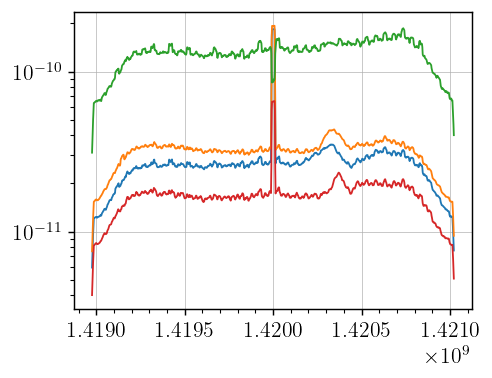

In [37]:
plt.semilogy(freq, clean_up((spectra[0] - noise)))
plt.semilogy(freq, clean_up((spectra[1] - noise)))
plt.semilogy(freq, clean_up((spectra[2] - noise)))
plt.semilogy(freq, clean_up((spec - noise)))
# plt.ylim(0.5e-10, 3e-10)

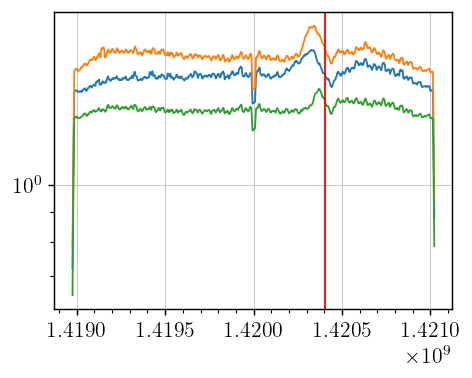

In [ ]:
plt.semilogy(freq, clean_up((spectra[0] / noise)))
plt.semilogy(freq, clean_up((spectra[1] / noise)))
# plt.semilogy(freq, clean_up((spectra[2] / noise)))
plt.semilogy(freq, clean_up((spec / noise)))

for i in sc.signal.find_peaks(spectra[0], width=5)[0]:
    plt.axvline(freq[i])

for i in sc.signal.find_peaks(spectra[1], width=5)[0]:
    plt.axvline(freq[i])

for i in sc.signal.find_peaks(spec, width=5)[0]:
    plt.axvline(freq[i])

plt.axvline(H21, c='r')
